In [1]:
import nibabel as nib
import numpy as np
import neuromaps
from os.path import join
from nilearn import maskers, masking, image, plotting
import scipy
from statsmodels.stats import multitest
import nilearn
from surfplot import Plot
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns




In [2]:
def read_gifti(gifti_fn):
    gii = nib.load(gifti_fn)
    data = np.vstack([da.data[np.newaxis, :]
                      for da in gii.darrays])
    return data

In [3]:
def plot_surf(surfaces, surf_lh, surf_rh, title):

    lh, rh = surfaces['inflated']

    p = Plot(surf_lh=lh, surf_rh=rh, size=(200, 600), zoom=1.6, layout='column')
    p.add_layer({'left': surf_lh, 
                'right': surf_rh}, #stimP_rh}, 
                cmap=cm.seismic, cbar=True)

    kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
            decimals=0, pad=0)
    fig = p.build(cbar_kws=kws)
    fig.axes[0].set_title(title, pad=-3)

    fig.show()

def hemisphere_r2(r2_lh, r2_rh, taskname):

    # Set the font family to Helvetica or Arial for the plot
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']  # Replace 'Helvetica' with 'Arial' for Arial font

    # plot R2
    # Index ranging from 1 to 20
    sns.set_style("white")
    # add vertical line
    plt.axvline(x=10, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=50, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=100, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=200, color='gray', linestyle='--', linewidth=1)

    index = range(0, 200,10)
    
    # Plot the data points
    sns.lineplot(x=index, y=r2_lh, marker='o', linestyle='-', color="green", label="Left hemi.")
    sns.lineplot(x=index, y=r2_rh, marker='o', linestyle='-', color="#FFA318", label="Right hemi.")

    plt.xlabel('No. of basis functions', fontsize=16)
    plt.ylabel('Reconstruction accuracy', fontsize=16)
    plt.title(f'Variance explained as a function of additive basis functions: task-{taskname}')
    plt.legend(loc='lower right')
    plt.xticks([0, 10, 50, 100, 200])
    plt.xlim(0, 200)
    plt.ylim(0, 1)
    sns.despine()
    plt.show()



In [4]:
def freq_filter_mat(basis_matrix, data_matrix, n_components):

    # linear combination left hemisphere
    Plh = basis_matrix[:n_components, :]
    F = Plh.T@Plh
    print(f"* frequency filter matrix {F.shape}\n* contrast map shape {data_matrix.shape}")
    reconstruct = data_matrix @ F
    return reconstruct


def load_mask(refimg_fname, mask_fname, smoothing):
    imgfname = refimg_fname# '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz'
    ref_img = image.load_img(imgfname)

    mask = image.load_img(mask_fname) #'/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii')
    mask_img = masking.compute_epi_mask(mask, target_affine = ref_img.affine, target_shape = ref_img.shape)

    nifti_masker = maskers.NiftiMasker(mask_img= mask_img,
                                            smoothing_fwhm=smoothing,
                                target_affine = ref_img.affine, target_shape = ref_img.shape, 
                        memory="nilearn_cache", memory_level=1)
    return nifti_masker
def mask_singletrial(npyarray, refimg_fname, nifti_masker):
    ref_img = image.load_img(refimg_fname)
    x,y,z=ref_img.shape
    masked_append = []
    for index in range(npyarray.shape[0]):
        masked_append.append(
            nifti_masker.fit_transform(
        image.new_img_like(ref_img, npyarray[index].reshape(x,y,z)))
        )
    masked_arr = np.vstack(masked_append)
    return masked_arr

def fdr_correct(masked_array, tvalues, qvalues, threshold, nifti_masker):
    result_mapp = np.zeros(masked_array.shape[1])
    result_mapp[qvalues < threshold] = tvalues[qvalues < threshold]
    con_tmapp = nifti_masker.inverse_transform(result_mapp)
    return con_tmapp


In [5]:
main_dir = '/Volumes/spacetop_projects_fractional'

# extract gii from cifti (bash)
INPUT="/tmp/spectral_bases_200.dscalar.nii"
OUTPUT="/tmp/basis_L.func.gii"
/Applications/workbench/bin_macosx64/wb_command -cifti-separate ${INPUT} COLUMN -metric CORTEX_LEFT ${OUTPUT}

INPUT="/tmp/spectral_bases_200.dscalar.nii"
OUTPUT="/tmp/basis_R.func.gii"
/Applications/workbench/bin_macosx64/wb_command -cifti-separate ${INPUT} COLUMN -metric CORTEX_RIGHT ${OUTPUT}


/Applications/workbench/bin_macosx64/wb_command -cifti-separate /Users/h/Documents/projects_local/sandbox/fmriprep_bold/surface/sub-0061_ses-01_task-social_acq-mb8_run-1_space-fsLR_den-91k_bold.dtseries.nii COLUMN -metric CORTEX_LEFT test_left.func.gii

## pain

In [6]:
# stack group surface maps
refimg_fname = join(main_dir, 'analysis/fmri/nilearn/glm/task-tomsaxe/sub-0002/sub-0002_ses-04_task-tomsaxe_run-01_con-01_desc-beliefGTphoto_stat-betamap.nii.gz')
mask_fname = '/Users/h/Documents/MATLAB/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii'
# masker: 
nifti_masker = load_mask(refimg_fname=refimg_fname,
                         mask_fname=mask_fname,
                         smoothing=6)

# transform vol to surf
posner_invalidGTvalid = neuromaps.transforms.mni152_to_fslr('/Users/h/Documents/projects_local/spacetop_fractional_analysis/scripts/step03_nilearn/second-level_task-posner_con-01_desc-invalidGTvalid_stat-betamap.nii.gz', fslr_density='32k', method='linear')

In [7]:
nib.save(posner_invalidGTvalid[0], join(main_dir, 'analysis/fmri/nilearn/basisfunction/posner_invalidGTvalid_lh.func.gii'))
nib.save(posner_invalidGTvalid[1], join(main_dir, 'analysis/fmri/nilearn/basisfunction/posner_invalidGTvalid_rh.func.gii'))

In [8]:
posner_invalidGTvalid_lh = posner_invalidGTvalid[0].darrays[0].data
posner_invalidGTvalid_rh = posner_invalidGTvalid[1].darrays[0].data

# basis function

In [ ]:
INPUT="/Users/h/Documents/projects_local/sandbox/eigenmodes/spectral_bases_200.dscalar.nii"
OUTPUT="/Users/h/Documents/projects_local/sandbox/eigenmodes/spectral_bases_200_L.func.gii"
/Applications/workbench/bin_macosx64/wb_command -cifti-separate ${INPUT} \
COLUMN -metric CORTEX_LEFT ${OUTPUT}

OUTPUT="/Users/h/Documents/projects_local/sandbox/eigenmodes/spectral_bases_200_R.func.gii"
/Applications/workbench/bin_macosx64/wb_command -cifti-separate ${INPUT} \
COLUMN -metric CORTEX_RIGHT s${OUTPUT}

In [9]:
# load basis functions
basis_dir = '/Users/h/Documents/projects_local/sandbox/eigenmodes'
basis_lh = read_gifti(join(basis_dir, 'spectral_bases_200_L.func.gii'))
basis_rh = read_gifti(join(basis_dir, 'spectral_bases_200_R.func.gii'))

# plot contrast and basis function just to check

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_28295/3632577384.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_28295/3632577384.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


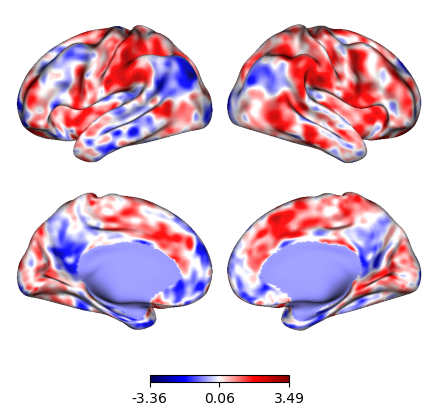

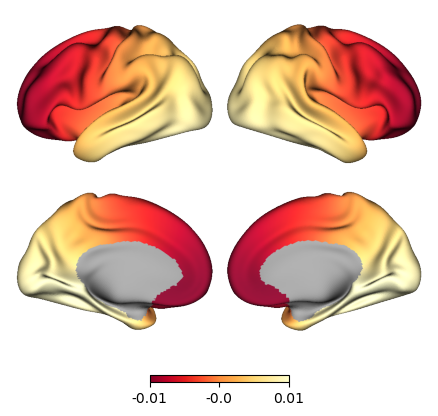

In [10]:
surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
lh, rh = surfaces['inflated']

p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer({'left': posner_invalidGTvalid_lh, 
             'right': posner_invalidGTvalid_rh}, 
             cmap=cm.seismic, cbar=True)
fig = p.build()
fig.show()

b = Plot(surf_lh=lh, surf_rh=rh)
b.add_layer({'left': basis_lh[1], 'right': basis_rh[1]}, cmap='YlOrRd_r', cbar=True)
fig = b.build()
fig.show()

In [11]:
np.sum(posner_invalidGTvalid_lh**2)

30019.19

In [12]:
def hemisphere_r2(r2_lh, r2_rh, taskname):

    # Set the font family to Helvetica or Arial for the plot
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']  # Replace 'Helvetica' with 'Arial' for Arial font

    # plot R2
    # Index ranging from 1 to 20
    sns.set_style("white")
    # add vertical line
    plt.axvline(x=10, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=50, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=100, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=200, color='gray', linestyle='--', linewidth=1)

    index = range(0, 200,10)
    
    # Plot the data points
    sns.lineplot(x=index, y=r2_lh, marker='o', linestyle='-', color="green", label="Left hemi.")
    sns.lineplot(x=index, y=r2_rh, marker='o', linestyle='-', color="#FFA318", label="Right hemi.")

    plt.xlabel('No. of basis functions', fontsize=16)
    plt.ylabel('Reconstruction accuracy', fontsize=16)
    plt.title(f'Variance explained as a function of additive basis functions: task-{taskname}')
    plt.legend(loc='lower right')
    plt.xticks([0, 10, 50, 100, 200])
    plt.xlim(0, 200)
    plt.ylim(0, 1)
    sns.despine()
    plt.show()

Text(0.5, 1.0, 'Example Line Plot')

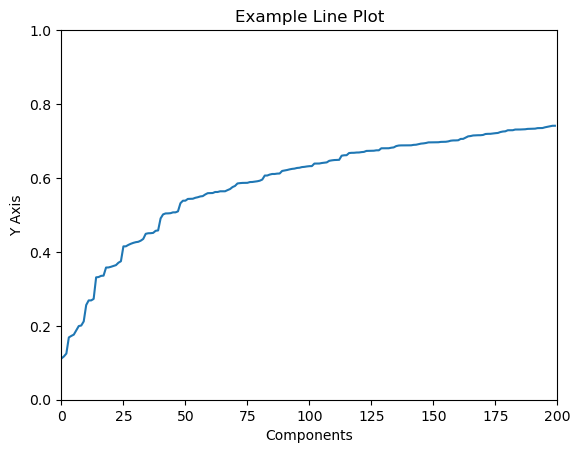

In [13]:
loadings = posner_invalidGTvalid_lh@basis_lh.T
# plt.plot((np.cumsum(loadings**2)/np.sum(posner_invalidGTvalid_lh**2,  keepdims=True)).T)
sns.lineplot((np.cumsum(loadings**2)/np.sum(posner_invalidGTvalid_lh**2,  keepdims=True)).T)
plt.xlim(0, 200)  # x-axis limits from 0 to 200
plt.ylim(0, 1)    # y-axis limits from 0 to 1

# Add labels and title
plt.xlabel('Components')
plt.ylabel('Y Axis')
plt.title('Example Line Plot')


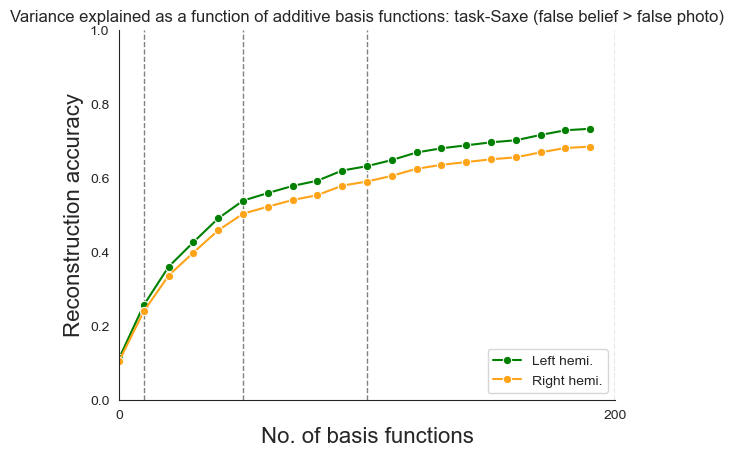

In [14]:
def hemisphere_r2_with_custom_x(reconstruct_lh, reconstruct_rh, x_limits, taskname):
    # Set the font family to Helvetica or Arial for the plot
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Helvetica']  # Replace 'Helvetica' with 'Arial' for Arial font

    # plot R2
    sns.set_style("white")
    # add vertical line
    plt.axvline(x=10, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=50, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=100, color='gray', linestyle='--', linewidth=1)
    plt.axvline(x=200, color='gray', linestyle='--', linewidth=1)

    index = range(0, len(reconstruct_lh), 10)  # Assuming data_array has 200 data points

    # Plot the data points
    sns.lineplot(x=index, y=reconstruct_lh[index], marker='o', linestyle='-', color="green", label="Left hemi.")
    sns.lineplot(x=index, y=reconstruct_rh[index], marker='o', linestyle='-', color="#FFA318", label="Right hemi.")

    plt.xlabel('No. of basis functions', fontsize=16)
    plt.ylabel('Reconstruction accuracy', fontsize=16)
    plt.title(f'Variance explained as a function of additive basis functions: task-{taskname}')
    plt.legend(loc='lower right')
    plt.xticks(x_limits)  # Set custom x-axis ticks using the x_limits
    plt.xlim(min(x_limits), max(x_limits))  # Set x-axis limits based on the x_limits
    plt.ylim(0, 1)
    sns.despine()
    plt.show()

# Example usage:
# Assuming you have the data array as mentioned:
reconstruct_lh = (np.cumsum(loadings**2)/np.sum(posner_invalidGTvalid_lh**2,  keepdims=True)).T #np.cumsum(loadings**2) / np.sum(posner_invalidGTvalid_lh**2, keepdims=True).T
reconstruct_rh = (np.cumsum(loadings**2)/np.sum(posner_invalidGTvalid_rh**2,  keepdims=True)).T 
x_limits = [0, 200]  # Set your desired x-axis limits here
taskname = "Saxe (false belief > false photo)"

hemisphere_r2_with_custom_x(reconstruct_lh, reconstruct_rh, x_limits, taskname)


## Bogdan method

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/1677086482.py:4: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* LH frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* RH frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/1677086482.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


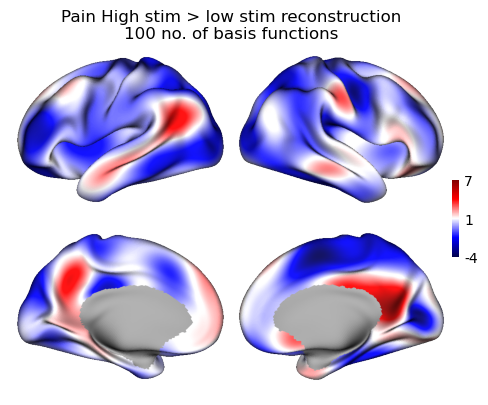

In [35]:
n_components = 100
# linear combination left hemisphere
Plh = basis_lh[:n_components, :]
F = Plh.T@Plh
print(f"* LH frequency filter matrix {F.shape}\n* contrast map shape {posner_invalidGTvalid_lh.shape}")
n_bf_stimHgtL_P_lh = posner_invalidGTvalid_lh @ F
# linear combination right hemisphere
Prh = basis_rh[:n_components, :]
F = Plh.T@Prh
print(f"* RH frequency filter matrix {F.shape}\n* contrast map shape {posner_invalidGTvalid_rh.shape}")
n_bf_stimHgtL_P_rh = posner_invalidGTvalid_rh @ F


surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
lh, rh = surfaces['inflated']

p = Plot(surf_lh=lh, surf_rh=rh)
p.add_layer({'left': n_bf_stimHgtL_P_lh, 
             'right': n_bf_stimHgtL_P_rh}, #stimP_rh}, 
             cmap=cm.seismic, cbar=True)

kws = dict(location='right', draw_border=False, aspect=10, shrink=.2,
           decimals=0, pad=0)
fig = p.build(cbar_kws=kws)
fig.axes[0].set_title(f'Pain High stim > low stim reconstruction\n{n_components} no. of basis functions', pad=-3)

fig.show()

/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/866909530.py:5: RuntimeWarning: invalid value encountered in matmul
  F = Plh.T@Plh


* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)
* frequency filter matrix (32492, 32492)
* contrast map shape (32492,)


/var/folders/sq/9y9jm3711js9zfqyb64n8c840000gn/T/ipykernel_23813/1452251319.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


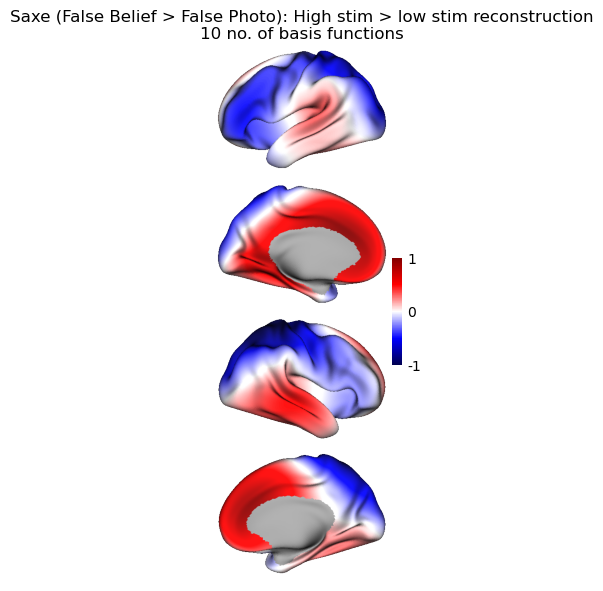

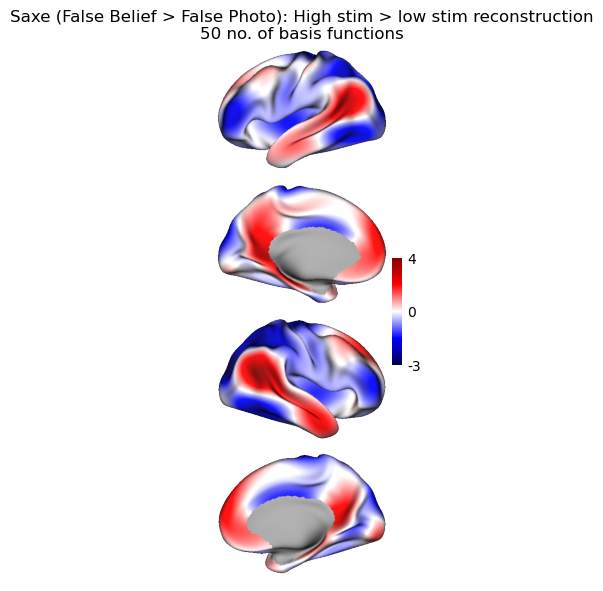

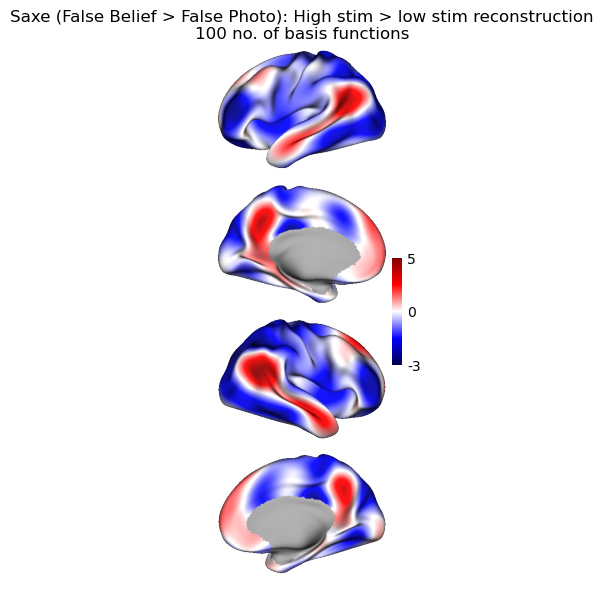

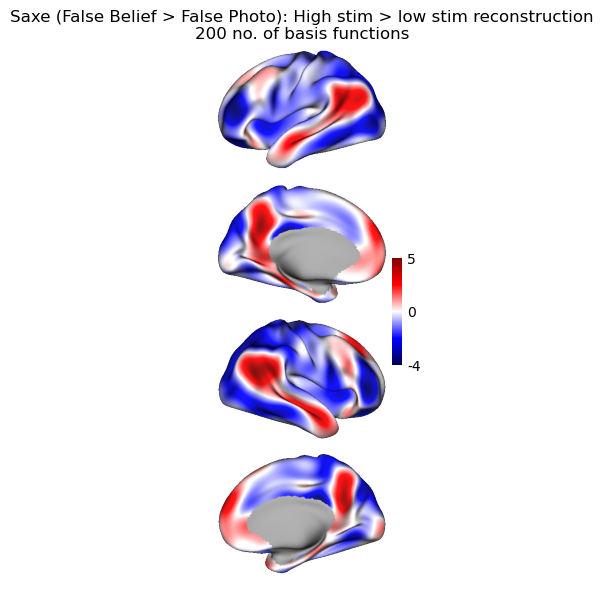

In [37]:
for n_components in [10, 50, 100, 200]:
    taskname = 'Saxe (False belief > False photo)'
    n_bf_stimHgtL_V_lh = freq_filter_mat(basis_matrix=basis_lh, data_matrix=posner_invalidGTvalid_lh, n_components=n_components)
    n_bf_stimHgtL_V_rh = freq_filter_mat(basis_matrix=basis_rh, data_matrix=posner_invalidGTvalid_rh, n_components=n_components)

    surfaces = neuromaps.datasets.fetch_fslr(density='32k', data_dir='/tmp')
    plot_surf(surfaces, 
            surf_lh=n_bf_stimHgtL_V_lh, 
            surf_rh= n_bf_stimHgtL_V_rh, 
            title=f'{taskname.title()}: False belief > False photo reconstruction\n{n_components} no. of basis functions')